In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import re
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

def get_optimal_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
        print("Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

device = get_optimal_device()

if device.type == 'mps':
    test_tensor = torch.randn(100, 100).to(device)
    result = torch.mm(test_tensor, test_tensor)
    print(f"MPS test successful - Tensor shape: {result.shape}")

print(f"Device: {device}")

Using Apple Silicon GPU (MPS)
MPS test successful - Tensor shape: torch.Size([100, 100])
Device: mps


## Tokenisation BPE (Byte Pair Encoding)

In [34]:
class SimpleBPE:
    def __init__(self, num_merges=1000):
        self.num_merges = num_merges
        self.word_freqs = {}
        self.splits = {}
        self.merges = {}
        self.vocab = set()
        self.word_boundary_token = "▁"
    
    def _get_word_freqs(self, corpus):
        word_freqs = {}
        words = corpus.lower().split()
        for word in words:
            word = re.sub(r'[^\w\s]', '', word)
            if word:
                word_with_boundary = self.word_boundary_token + word
                word_freqs[word_with_boundary] = word_freqs.get(word_with_boundary, 0) + 1
        return word_freqs
    
    def _get_splits(self, word_freqs):
        splits = {}
        for word, freq in word_freqs.items():
            splits[word] = list(word)
        return splits
    
    def _get_pair_freqs(self, splits):
        pair_freqs = {}
        for word, freq in self.word_freqs.items():
            split = splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] = pair_freqs.get(pair, 0) + freq
        return pair_freqs
    
    def _merge_vocab(self, pair, splits):
        new_splits = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in splits:
            new_word = p.sub(''.join(pair), ' '.join(splits[word]))
            new_splits[word] = new_word.split()
        return new_splits
    
    def train(self, corpus):
        self.word_freqs = self._get_word_freqs(corpus)
        self.splits = self._get_splits(self.word_freqs)
        
        for word in self.word_freqs:
            for char in word:
                self.vocab.add(char)
        
        for i in range(self.num_merges):
            pair_freqs = self._get_pair_freqs(self.splits)
            if not pair_freqs:
                break
            
            best_pair = max(pair_freqs, key=pair_freqs.get)
            self.splits = self._merge_vocab(best_pair, self.splits)
            self.merges[best_pair] = i
            self.vocab.add(''.join(best_pair))
        
        self.vocab = sorted(list(self.vocab))
        self.token_to_idx = {token: i for i, token in enumerate(self.vocab)}
        self.idx_to_token = {i: token for i, token in enumerate(self.vocab)}
    
    def tokenize(self, text):
        words = text.lower().split()
        tokens = []
        
        for word in words:
            word = re.sub(r'[^\w\s]', '', word)
            if not word:
                continue
            
            word_with_boundary = self.word_boundary_token + word
            word_tokens = list(word_with_boundary)
            
            for pair in self.merges:
                new_word_tokens = []
                i = 0
                while i < len(word_tokens):
                    if (i < len(word_tokens) - 1 and 
                        word_tokens[i] == pair[0] and 
                        word_tokens[i + 1] == pair[1]):
                        new_word_tokens.append(''.join(pair))
                        i += 2
                    else:
                        new_word_tokens.append(word_tokens[i])
                        i += 1
                word_tokens = new_word_tokens
            
            tokens.extend(word_tokens)
        
        return tokens
    
    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.token_to_idx.get(token, 0) for token in tokens]
    
    def decode(self, indices):
        tokens = [self.idx_to_token.get(idx, '') for idx in indices]
        
        text = ""
        for token in tokens:
            if token.startswith(self.word_boundary_token):
                if text:
                    text += " "
                text += token[1:]
            else:
                text += token
        
        return text

# Test tokenizer
sample_text = "Harry Potter walked through the magical forest with his friends"
bpe = SimpleBPE(num_merges=50)
bpe.train(sample_text)

print(f"Vocabulary size: {len(bpe.vocab)}")
decoded = bpe.decode(bpe.encode(sample_text))
print(f"Test encoding/decoding: {decoded}")

Vocabulary size: 68
Test encoding/decoding: harry potter walked through the magical forest with his friends


## Dataset personnalisé Harry Potter

In [35]:
def clean_harry_potter_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    content = re.sub(r'^\s*\d+→', '', content, flags=re.MULTILINE)
    content = re.sub(r'^\s*\d+\s*$', '', content, flags=re.MULTILINE)
    content = re.sub(r'^\s*[ivxlcdm]+\s*$', '', content, flags=re.MULTILINE)
    content = re.sub(r'^\s*\d+\s+[A-Z][^a-z]*\d*\s*$', '', content, flags=re.MULTILINE)
    content = re.sub(r'[^\w\s.,!?;:\-"\'()]', ' ', content)
    content = re.sub(r'\n\s*\n', '\n', content)
    content = re.sub(r'\s+', ' ', content)
    
    return content.strip()

class HarryPotterDataset(Dataset):
    def __init__(self, text, tokenizer, seq_length=32):
        self.tokenizer = tokenizer
        self.seq_length = seq_length
        
        self.tokens = self.tokenizer.encode(text)
        
        self.sequences = []
        self.targets = []
        
        for i in range(len(self.tokens) - seq_length):
            self.sequences.append(self.tokens[i:i + seq_length])
            self.targets.append(self.tokens[i + 1:i + seq_length + 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )

# Load and clean dataset
harry_text = clean_harry_potter_text('data/harry_dataset.txt')
print(f"Text cleaned: {len(harry_text)} characters")

# Train BPE tokenizer
print("Training BPE tokenizer...")
harry_bpe = SimpleBPE(num_merges=2000)
harry_bpe.train(harry_text)
print(f"Vocabulary: {len(harry_bpe.vocab)} tokens")

# Create dataset
seq_length = 32 if device.type == 'mps' else 16
harry_dataset = HarryPotterDataset(harry_text, harry_bpe, seq_length=seq_length)
print(f"Dataset created: {len(harry_dataset)} sequences")

# Configure DataLoader
if device.type == 'mps':
    batch_size = 64
    num_workers = 0
    pin_memory = False
else:  # CPU
    batch_size = 16
    num_workers = 2
    pin_memory = False

harry_dataloader = DataLoader(
    harry_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print(f"DataLoader created: batch_size={batch_size}")

Text cleaned: 1131049 characters
Training BPE tokenizer...
Vocabulary: 2042 tokens
Dataset created: 274087 sequences
DataLoader created: batch_size=64


## Modèle LSTM pour génération de texte Harry Potter

In [36]:
class HarryPotterLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(HarryPotterLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device))

# Model parameters based on device
if device.type == 'mps':
    embedding_dim = 128
    hidden_dim = 256
    num_layers = 2
    learning_rate = 0.001
else:  # CPU
    embedding_dim = 64
    hidden_dim = 128
    num_layers = 1
    learning_rate = 0.01

# Create model
harry_model = HarryPotterLSTM(
    len(harry_bpe.vocab), 
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(harry_model.parameters(), lr=learning_rate, weight_decay=1e-5)

total_params = sum(p.numel() for p in harry_model.parameters())
print(f"Model created: {total_params/1e6:.2f}M parameters")

# Training function with TensorBoard
def train_harry_model(model, dataloader, epochs=5):
    writer = SummaryWriter('runs/harry_potter_training')
    model.train()
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_start = time.time()
        
        for batch_idx, (sequences, targets) in enumerate(dataloader):
            sequences, targets = sequences.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            hidden = model.init_hidden(sequences.size(0), device)
            
            output, _ = model(sequences, hidden)
            loss = criterion(output.view(-1, len(harry_bpe.vocab)), targets.view(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Log to TensorBoard every 1000 batches
            if batch_idx % 1000 == 0 and batch_idx > 0:
                writer.add_scalar('Training/Batch_Loss', loss.item(), epoch * len(dataloader) + batch_idx)
        
        avg_loss = epoch_loss / len(dataloader)
        epoch_time = time.time() - epoch_start
        
        # Log epoch metrics to TensorBoard
        writer.add_scalar('Training/Epoch_Loss', avg_loss, epoch)
        writer.add_scalar('Training/Epoch_Time', epoch_time, epoch)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Time: {epoch_time:.1f}s")
    
    total_time = time.time() - start_time
    writer.add_scalar('Training/Total_Time', total_time, 0)
    writer.close()
    
    print(f"Training completed in {total_time:.1f}s")

# Train model
epochs = 5
train_harry_model(harry_model, harry_dataloader, epochs=epochs)

Model created: 1.71M parameters
Starting training: 5 epochs
Epoch 1/5 - Loss: 4.8295 - Time: 70.8s
Epoch 2/5 - Loss: 4.1565 - Time: 70.5s
Epoch 3/5 - Loss: 3.9642 - Time: 71.5s
Epoch 4/5 - Loss: 3.8516 - Time: 71.4s
Epoch 5/5 - Loss: 3.7762 - Time: 70.3s
Training completed in 354.5s


## Génération de texte dans le style Harry Potter

In [37]:
def generate_harry_potter_text(model, tokenizer, seed="Harry", length=100, temperature=0.8):
    model.eval()
    with torch.no_grad():
        tokens = tokenizer.encode(seed.lower())
        generated_tokens = tokens.copy()
        
        hidden = model.init_hidden(1, device)
        
        for _ in range(length):
            seq_len = min(32, len(generated_tokens))
            input_seq = torch.tensor([generated_tokens[-seq_len:]], dtype=torch.long).to(device)
            
            output, hidden = model(input_seq, hidden)
            
            probs = F.softmax(output[0, -1] / temperature, dim=0)
            next_token_idx = torch.multinomial(probs, 1).item()
            
            generated_tokens.append(next_token_idx)
            
            if len(generated_tokens) > 50:
                decoded_so_far = tokenizer.decode(generated_tokens)
                if any(end in decoded_so_far[-10:] for end in ['. ', '! ', '? ']):
                    break
        
        return tokenizer.decode(generated_tokens)

# Generate sample texts
seeds = ["Harry Potter", "Hermione", "The dark wizard", "Magic spells", "Hogwarts"]
for i, seed in enumerate(seeds, 1):
    generated_text = generate_harry_potter_text(harry_model, harry_bpe, seed, length=80, temperature=0.7)
    clean_text = generated_text.strip()
    if clean_text:
        clean_text = clean_text[0].upper() + clean_text[1:] if len(clean_text) > 1 else clean_text.upper()
    print(f"Text {i} (seed: '{seed}'):")
    print(f"   {clean_text}")
    print()

# Temperature comparison
seed = "The young wizard"
for temp in [0.5, 0.8, 1.2]:
    generated = generate_harry_potter_text(harry_model, harry_bpe, seed, length=60, temperature=temp)
    clean_generated = generated.strip()
    if clean_generated:
        clean_generated = clean_generated[0].upper() + clean_generated[1:] if len(clean_generated) > 1 else clean_generated.upper()
    print(f"Temperature {temp}: {clean_generated}")
    print()

Text 1 (seed: 'Harry Potter'):
   Harry potter was the lost diadem i need to ﬁnd out of your pale if you will have to be able to talk to ourselves and i ve got a idea in a trace the silver doe which he was state that s no you need to get it in the middle of the castle that s i m going to stop his goblet but s good pointed as though he had covered his r

Text 2 (seed: 'Hermione'):
   Hermione s wand and examined it the newspain of unknown ﬂame was department of the boy and an books of spectangles in a drawing room with the headmaster s oﬃce still swallowed the black cloak and the sound of the family had left the other two death eaters from the locket too has the refues of the dragon he could not see ron

Text 3 (seed: 'The dark wizard'):
   The dark wizard who had been understood harry could not help himself but then he was saying so he felt a tall maimed vastly quinch and leapt into the other hal a ghost of reachless water belowwolf and kisy cross to the ﬂoor the oﬃcial exhaco mus oh y

## 3. Analyse de Sentiments

In [38]:
# Charger et préparer les données de sentiment depuis le fichier
def load_sentiment_data(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    texts.append(parts[0])
                    labels.append(int(parts[1]))
    return texts, labels

# Charger les données
texts, labels = load_sentiment_data('data/sentiment_data.txt')

# Créer l'encodeur pour les sentiments
sentiment_encoder = SimpleEncoder()
all_text = ' '.join(texts)
sentiment_encoder.fit(all_text)

print(f"Données chargées: {len(texts)} exemples")
print(f"Vocabulaire sentiment: {sentiment_encoder.vocab_size} caractères")
print(f"Répartition: {sum(labels)} positifs, {len(labels) - sum(labels)} négatifs")

Données chargées: 90 exemples
Vocabulaire sentiment: 35 caractères
Répartition: 50 positifs, 40 négatifs


In [39]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 classes : positif/négatif
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.dropout(hidden[-1])  # Utiliser le dernier état caché
        output = self.fc(output)
        return output

def prepare_sentiment_data(texts, labels, encoder, max_len=30):
    sequences = []
    for text in texts:
        indices = [encoder.char_to_idx.get(char, 0) for char in text[:max_len]]
        # Padding
        if len(indices) < max_len:
            indices.extend([0] * (max_len - len(indices)))
        sequences.append(indices)
    
    return torch.tensor(sequences), torch.tensor(labels)

# Préparer les données
X_sentiment, y_sentiment = prepare_sentiment_data(texts, labels, sentiment_encoder)

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_sentiment, y_sentiment, test_size=0.3, random_state=42
)

print(f"Train: {X_train.shape[0]} exemples")
print(f"Test: {X_test.shape[0]} exemples")

Train: 63 exemples
Test: 27 exemples


Entraînement du modèle de sentiment...
Epoch 20, Loss: 0.3362, Test Acc: 0.3704
Epoch 40, Loss: 0.0902, Test Acc: 0.5185
Epoch 60, Loss: 0.0840, Test Acc: 0.5556
Epoch 80, Loss: 0.0802, Test Acc: 0.5185
Epoch 100, Loss: 0.0839, Test Acc: 0.4815


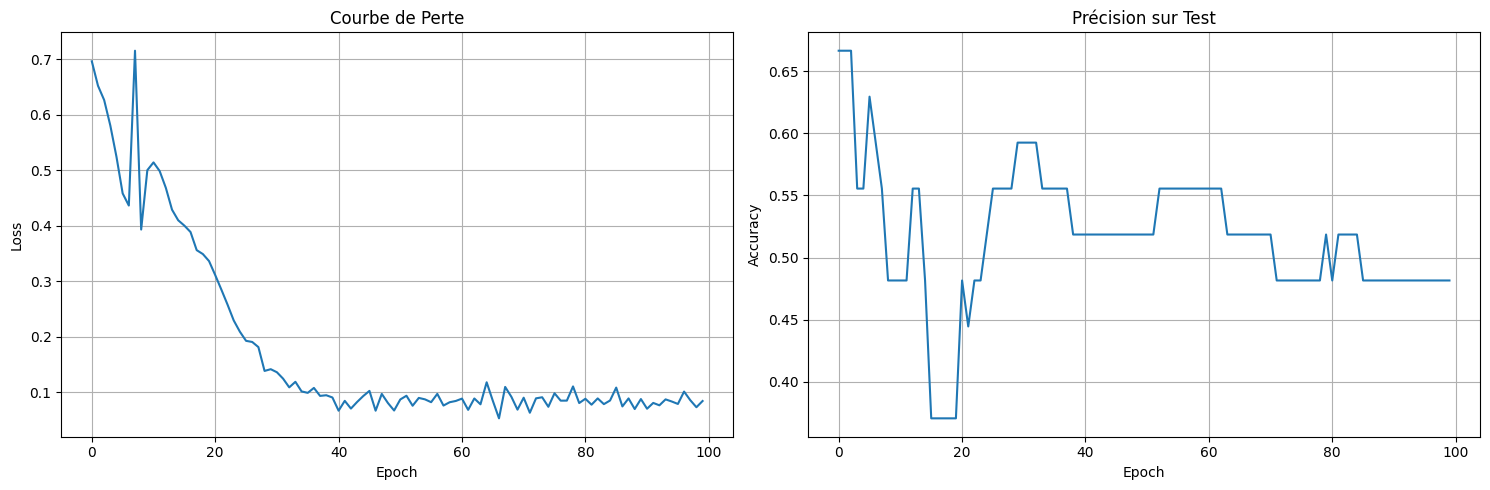

Précision finale: 0.4815


In [40]:
# Créer et entraîner le modèle de sentiment
sentiment_model = SentimentLSTM(sentiment_encoder.vocab_size, 32, 64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sentiment_model.parameters(), lr=0.01)

def train_sentiment_model(model, X_train, y_train, X_test, y_test, epochs=100):
    train_losses, test_accuracies = [], []
    
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Évaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.argmax(test_outputs, dim=1)
            accuracy = (predicted == y_test).float().mean().item()
            test_accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Acc: {accuracy:.4f}')
    
    return train_losses, test_accuracies

print("Entraînement du modèle de sentiment...")
losses, accuracies = train_sentiment_model(
    sentiment_model, X_train, y_train, X_test, y_test, epochs=100
)

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(losses)
ax1.set_title('Courbe de Perte')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(accuracies)
ax2.set_title('Précision sur Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Précision finale: {accuracies[-1]:.4f}")

### Test du modèle de sentiment

In [41]:
def predict_sentiment(model, encoder, text, max_len=30):
    model.eval()
    with torch.no_grad():
        indices = [encoder.char_to_idx.get(char, 0) for char in text[:max_len]]
        if len(indices) < max_len:
            indices.extend([0] * (max_len - len(indices)))
        
        input_tensor = torch.tensor([indices])
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
        
        sentiment = "Positif" if predicted_class == 1 else "Négatif"
        return sentiment, confidence

# Tester sur de nouveaux exemples
test_sentences = [
    "J'adore ce nouveau livre",
    "Cette journée est horrible",
    "Je me sens bien aujourd'hui",
    "C'est une catastrophe",
    "Quelle merveilleuse surprise",
    "Je suis déçu",
    "Le soleil brille et tout va bien",
    "Cette situation me rend anxieux"
]

print("Test du classifieur de sentiment :")
print("=" * 50)

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentiment_model, sentiment_encoder, sentence)
    print(f"'{sentence}' -> {sentiment} ({confidence:.3f})")
    print("-" * 40)

Test du classifieur de sentiment :
'J'adore ce nouveau livre' -> Négatif (0.982)
----------------------------------------
'Cette journée est horrible' -> Négatif (0.989)
----------------------------------------
'Je me sens bien aujourd'hui' -> Négatif (0.674)
----------------------------------------
'C'est une catastrophe' -> Négatif (0.998)
----------------------------------------
'Quelle merveilleuse surprise' -> Positif (0.986)
----------------------------------------
'Je suis déçu' -> Négatif (1.000)
----------------------------------------
'Le soleil brille et tout va bien' -> Positif (0.999)
----------------------------------------
'Cette situation me rend anxieux' -> Négatif (0.994)
----------------------------------------
